# Basic Time Series Analysis

In [1]:
# Basic packages
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd  # generating random numbers
import datetime  # manipulating date formats
# Viz
import matplotlib.pyplot as plt  # basic plotting
import seaborn as sns  # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# settings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Reading the data
google = pd.read_csv(filepath_or_buffer='dataset/GOOGLE_2006-01-01_to_2018-01-01.csv')

In [3]:
# Checking the data both head and tail
print(google.head())
print(google.tail())
print('\nDataSet size %d' % google.size)

         Date    Open    High     Low   Close    Volume   Name
0  2006-01-03  211.47  218.05  209.32  217.83  13137450  GOOGL
1  2006-01-04  222.17  224.70  220.09  222.84  15292353  GOOGL
2  2006-01-05  223.22  226.00  220.97  225.85  10815661  GOOGL
3  2006-01-06  228.66  235.49  226.85  233.06  17759521  GOOGL
4  2006-01-09  233.44  236.94  230.70  233.68  12795837  GOOGL
            Date     Open     High      Low    Close   Volume   Name
3014  2017-12-22  1070.00  1071.72  1067.64  1068.86   889446  GOOGL
3015  2017-12-26  1068.64  1068.86  1058.64  1065.85   918767  GOOGL
3016  2017-12-27  1066.60  1068.27  1058.38  1060.20  1116203  GOOGL
3017  2017-12-28  1062.25  1064.84  1053.38  1055.95   994249  GOOGL
3018  2017-12-29  1055.49  1058.05  1052.70  1053.40  1180340  GOOGL

DataSet size 21133


In [4]:
# Dataset information
google.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 7 columns):
Date      3019 non-null object
Open      3019 non-null float64
High      3019 non-null float64
Low       3019 non-null float64
Close     3019 non-null float64
Volume    3019 non-null int64
Name      3019 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 165.2+ KB


## Single Series
The goal of this basic analysis is to try predict the next close value of the google shares.

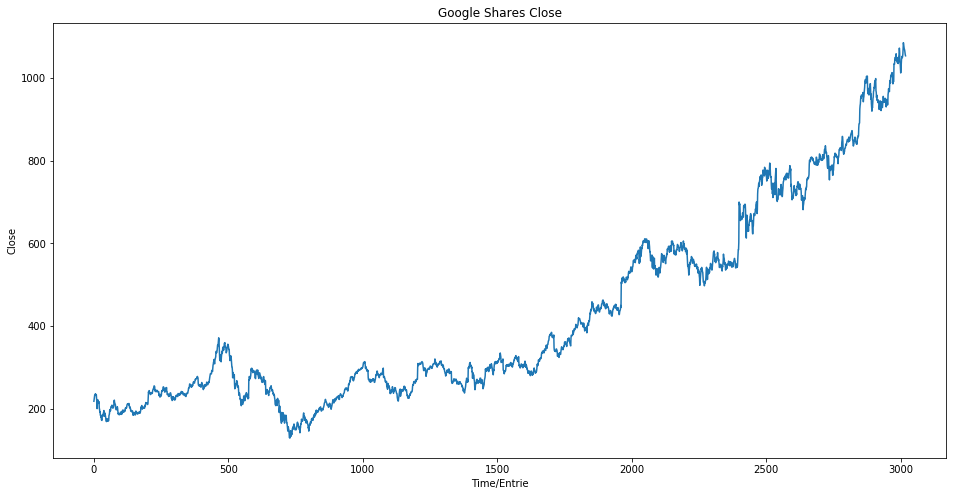

In [5]:
# Plot of the close series
plt.figure(figsize=(16, 8))
plt.title('Google Shares Close')
plt.xlabel('Time/Entrie')
plt.ylabel('Close')
plt.plot(google['Close'])
plt.show(True)

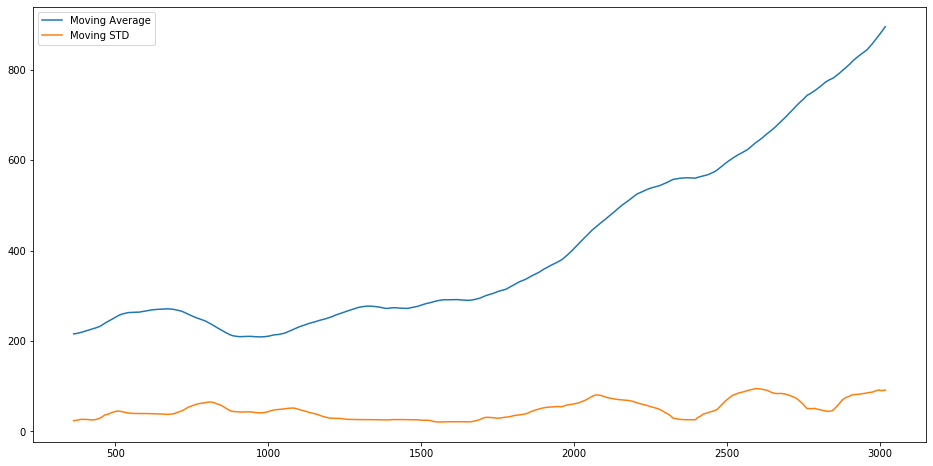

In [6]:
# Plotting the moving average and the moving standard deviation
plt.figure(figsize=(16, 8))
plt.plot(google['Close'].rolling(window=365, center=False).mean(), label='Moving Average')
plt.plot(google['Close'].rolling(window=365, center=False).std(), label='Moving STD')
plt.legend()

# Bigger the window(lag) more smooth it gets
# 31 because we have daily data so we are doing the moving average between months

## Properties and types of series

* **Trend** : A long-term increase or decrease in the data. This can be seen as a slope (is doesn’t have to be linear) roughly going through the data.

* **Seasonality** : A time series is said to be seasonal when it is affected by seasonal factors (hour of day, week, month, year, etc.). Seasonality can be observed with nice cyclical patterns of fixed frequency.

* **Cyclicity** : A cycle occurs when the data exhibits rises and falls that are not of a fixed frequency. These fluctuations are usually due to economic conditions, and are often related to the “business cycle”. The duration of these fluctuations is usually at least 2 years.

* **Residuals** : Each time series can be decomposed in two parts:
    - A forecast, made up of one or several forecasted values
    - Residuals. They are the difference between an observation and its predicted value at each time step. 


Remember that:  
**Value of series at time t = Predicted value at time t + Residual at time t**

<img src='images/tsprops.png'>

## Quick Observations

Looking at the moving average plot we can notice a trend and maybe a possible seasonality, we are going to use a multiplicative version of a seasonal decomposition using stats model **sm** modulem, which tries to decompose a time series in three main components Trend, Seasonality and the Residual.

$$y = Trend*Seasonal*Residual$$


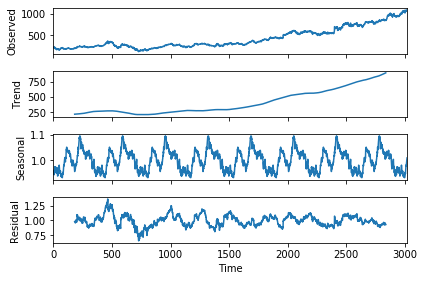

In [7]:
# Multiplicative
y = sm.tsa.seasonal_decompose(
    google['Close'].values, freq=365, model='multiplicative')

fig = y.plot()

## Stationarity
Stationarity is the time-invariance of a time series i.e two points of the same time series are related to each other by only how far they apart they are, and not by the direction(forward/backward).

<img src='images/stationgraph.png'>

We can use the following tests to check the stationarity of a time series:
* ADF(Augmented Dicky Fuller Test)
* KPSS(Kwiatkowski–Phillips–Schmidt–Shin)
* PP(Phillips-Perron)

**The most commonly used is the ADF**

In [8]:
def stationarity_test(ts):
    """
    Perfoms the Dickey Fuller test to check wether a series is stationary or not
    (Tries to find unit roots with t student tests?)
    """

    # adf : float
    #     Test statistic
    # pvalue : float
    #     MacKinnon's approximate p-value based on MacKinnon (1994, 2010)
    # usedlag : int
    #     Number of lags used
    # nobs : int
    #     Number of observations used for the ADF regression and calculation of
    #     the critical values
    # critical values : dict
    #     Critical values for the test statistic at the 1 %, 5 %, and 10 %
    #     levels. Based on MacKinnon (2010)
    # icbest : float
    #     The maximized information criterion if autolag is not None.
    # resstore : ResultStore, optional
    #     A dummy class with results attached as attributes

    adf = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(adf[0:4], index=[
                         'Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    for key, value in adf[4].items():
        dfoutput['Critical Value (%s)' % key] = value

    print(dfoutput)

In [9]:
stationarity_test(google['Close'])

Test Statistic                    1.322424
p-value                           0.996732
#Lags Used                       29.000000
Number of Observations Used    2989.000000
Critical Value (1%)              -3.432540
Critical Value (5%)              -2.862507
Critical Value (10%)             -2.567285
dtype: float64


The above results specially the p-value tells us that we cannot reject the null hypothesis i.e our series is not stationary.

We are going to perfome some operations on the series so we can get a better p-value and a better series to do the forecasting.

<Figure size 432x288 with 0 Axes>

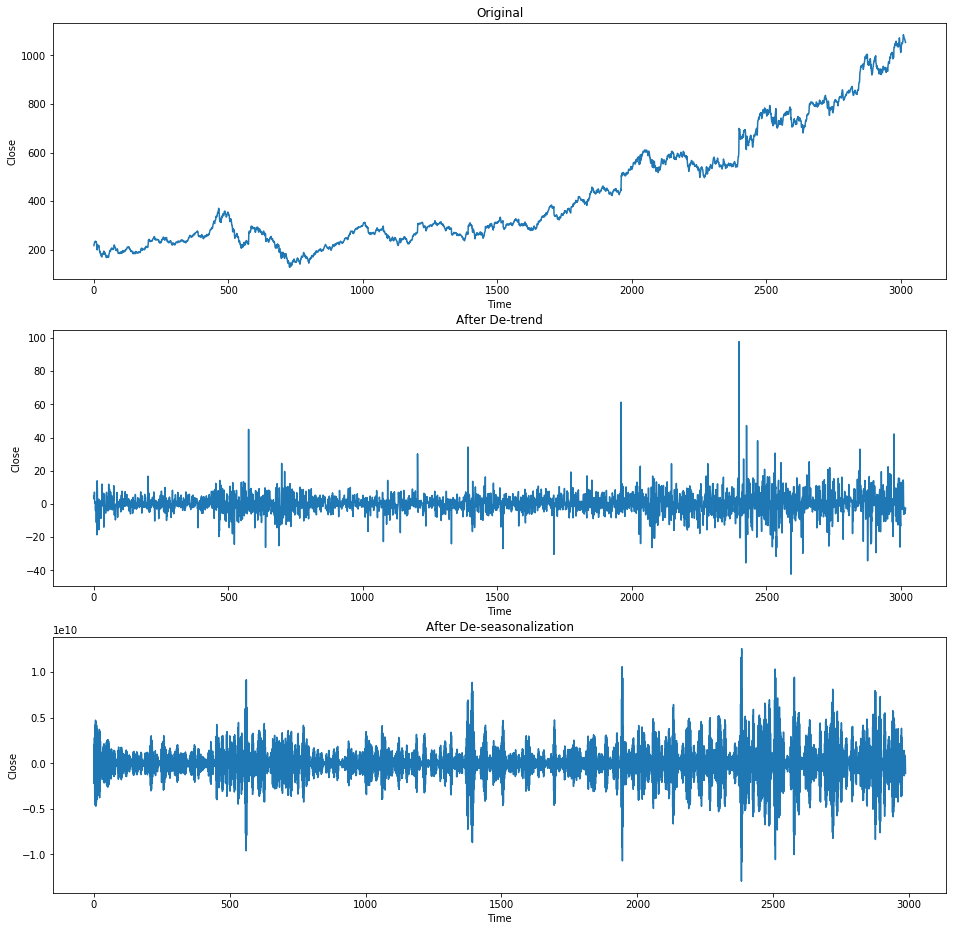

In [10]:
plt.tight_layout()
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Close')
plt.plot(google['Close'])

plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Close')
new_ts=np.diff(google['Close'], n=1)
plt.plot(new_ts)

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Close')
new_ts=np.diff(google['Close'], n=31)       # assuming the seasonality is 12 months long
plt.plot(new_ts)

In [11]:
stationarity_test(new_ts)

Test Statistic                  -58.284086
p-value                           0.000000
#Lags Used                       26.000000
Number of Observations Used    2961.000000
Critical Value (1%)              -3.432560
Critical Value (5%)              -2.862517
Critical Value (10%)             -2.567290
dtype: float64


Now after the transformations, our p-value for the DF test is well within 5 %. **Hence we can assume Stationarity of the series**

## Forecasting

After checking the stationarity we can use the ARIMA models to forecast our time series.

In [12]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        # Defining the subplot axes
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        # Auto correlation plot(MA)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        # Parcial ACF(AR)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
        plt.plot()

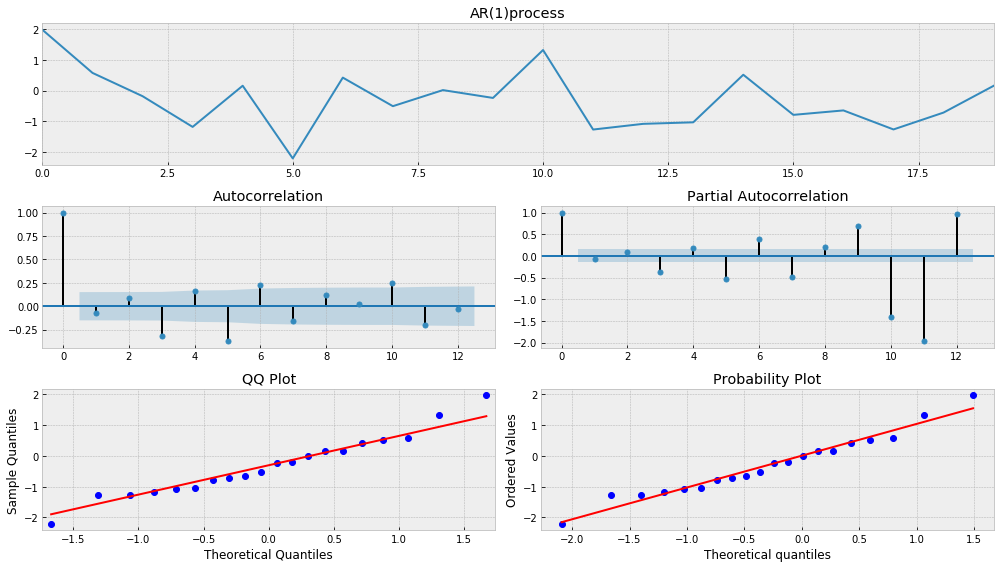

In [33]:
# Simulate an AR(1) process with alpha = 0.6
np.random.seed(1)
n_samples = int(100)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")

Because it is an AR(1) process the PACF cuts the lag at 1

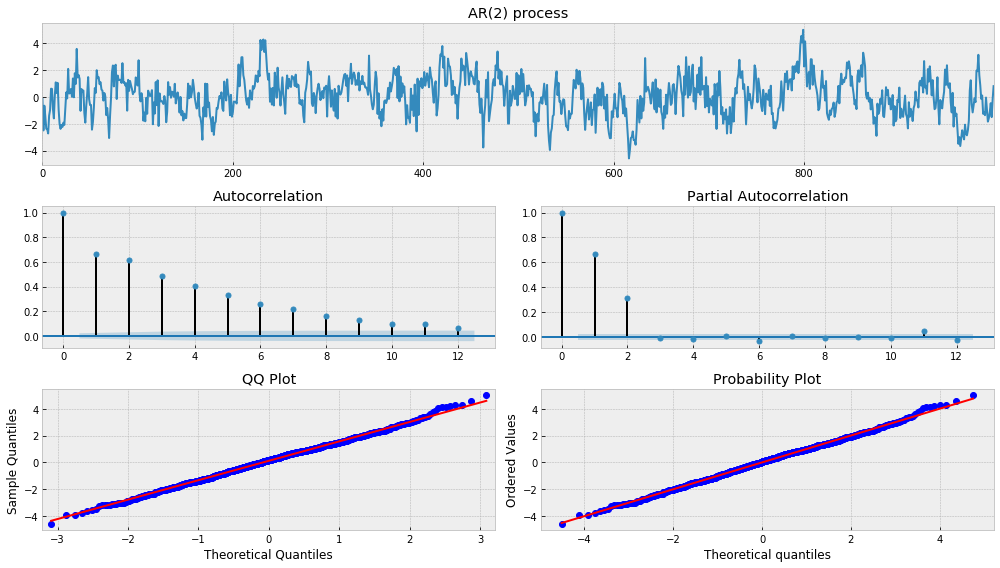

In [14]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.444, 0.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=12,title="AR(2) process")

AR(2) process has ACF tailing out and PACF cutting off at lag=2

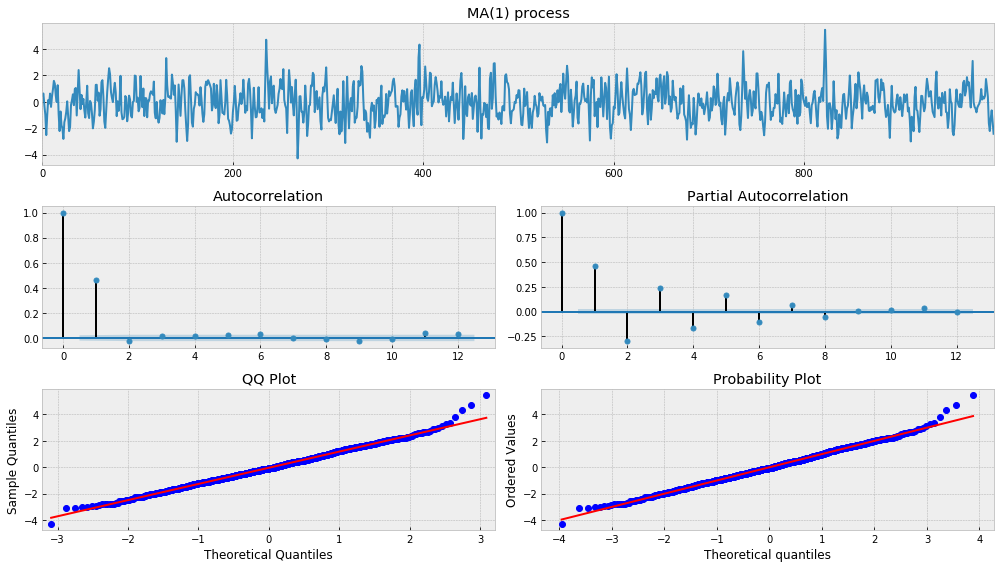

In [15]:
# Simulate an MA(1) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.8])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
limit=12
_ = tsplot(ma1, lags=limit,title="MA(1) process")

MA(1) process has ACF cut off at lag=1¶

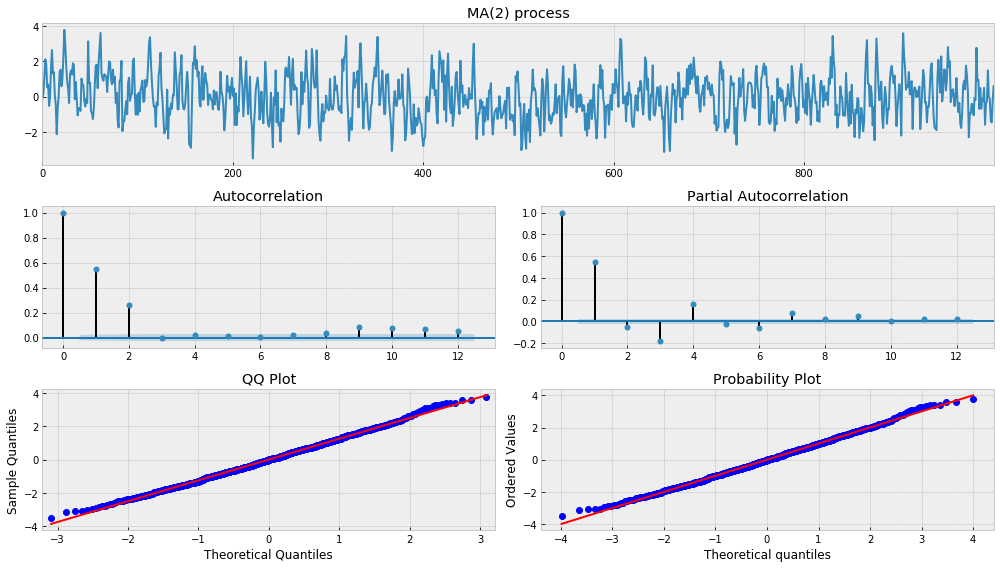

In [16]:
# Simulate MA(2) process with betas 0.6, 0.4
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma2, lags=12,title="MA(2) process")

MA(2) process has ACF cut off at lag=2

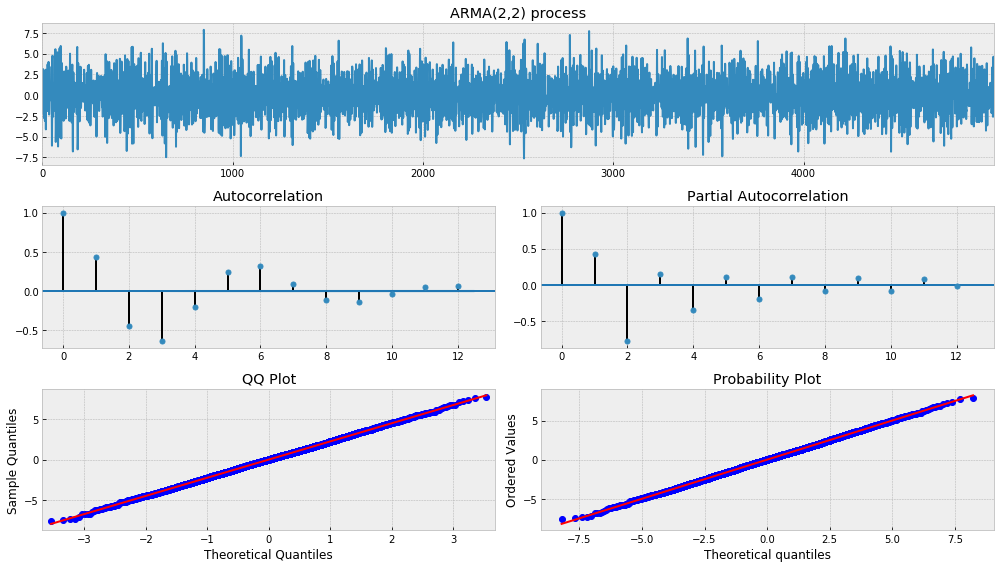

In [17]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")

The ARMA(2,2) ACF and PACF plots are not very straight forward.

Summary of the plots and how to evaluate them:

<table>
<thead><tr>
<th>ACF Shape</th>
<th>Indicated Model</th>
</tr>
</thead>
<tbody>
<tr>
<td>Exponential, decaying to zero</td>
<td>Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model</td>
<td></td>
</tr>
<tr>
<td>Alternating positive and negative, decaying to zero Autoregressive model.</td>
<td>Use the partial autocorrelation plot to help identify the order.</td>
<td></td>
</tr>
<tr>
<td>One or more spikes, rest are essentially zero</td>
<td>Moving average model, order identified by where plot becomes zero.</td>
<td></td>
</tr>
<tr>
<td>Decay, starting after a few lags</td>
<td>Mixed autoregressive and moving average (ARMA) model.</td>
<td></td>
</tr>
<tr>
<td>All zero or close to zero</td>
<td>Data are essentially random.</td>
<td></td>
</tr>
<tr>
<td>High values at fixed intervals</td>
<td>Include seasonal autoregressive term.</td>
<td></td>
</tr>
<tr>
<td>No decay to zero</td>
<td>Series is not stationary</td>
<td></td>
</tr>
</tbody>
</table>

Using a systematic approach to find the order of AR and MA processes.

Using the **The Akaike information criterion (AIC)** which is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection.

In [18]:
# pick best order by aic
# smallest aic value wins
def find_arma_order(tseries, max_ar, max_ma):
    order_selection = arma_order_select_ic(arma22, max_ar=max_ar, max_ma=max_ma, ic="aic", trend='nc')
    print('Best order found %s' % str(order_selection['aic_min_order']))
    
    return order_selection['aic_min_order']

In [19]:
# Using on the simulated ARMA(2,2)
find_arma_order(arma22, max_ar=3, max_ma=3)

Best order found (2, 2)


(2, 2)

Found that the ARMA is (2,2).

Now we are going to use on our series.

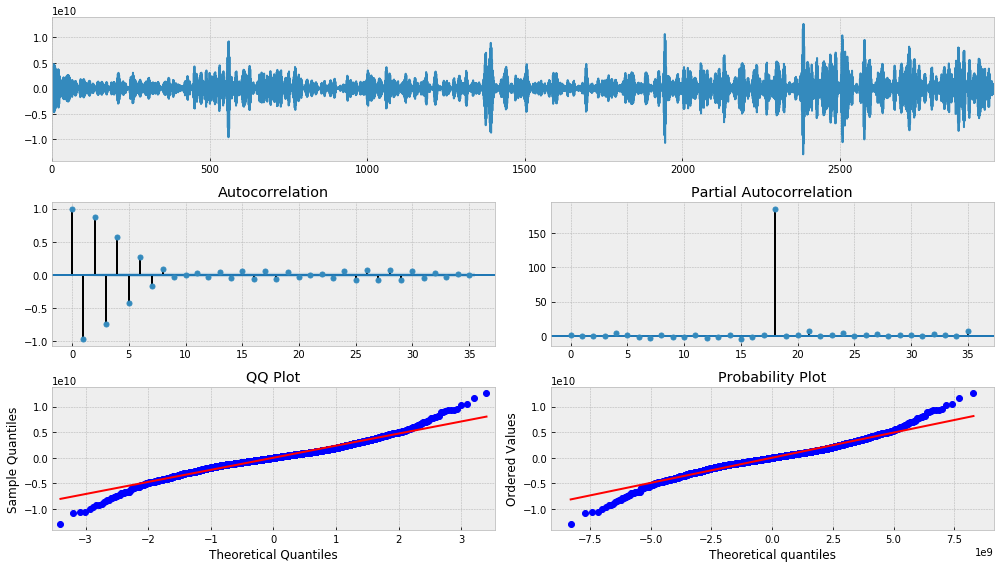

In [20]:
tsplot(new_ts)

In [21]:
best_order = find_arma_order(new_ts, 3, 0)

Best order found (3, 0)


In [22]:
model = smt.ARMA(new_ts[:2400], order=(3, 0)).fit(method='mle', trend='nc')

<function matplotlib.pyplot.legend(*args, **kwargs)>

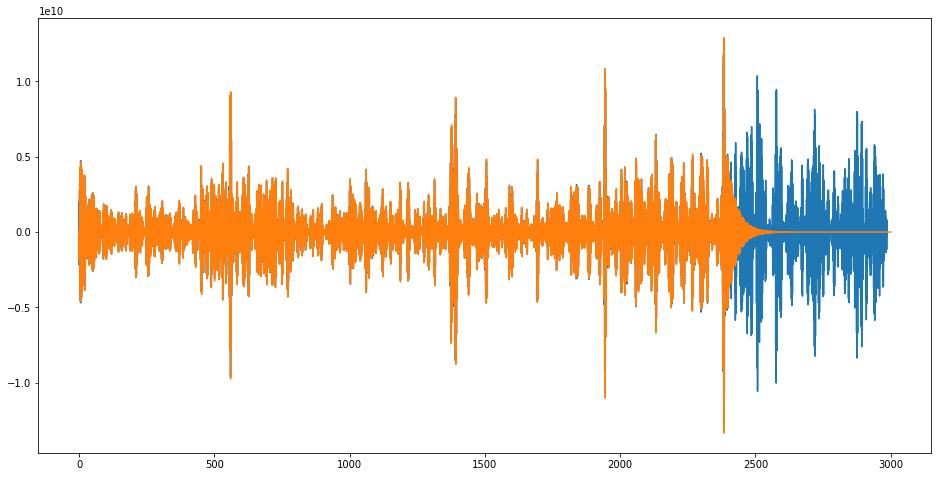

In [23]:
plt.figure(figsize=(16, 8))
plt.plot(new_ts, label='Original')
plt.plot(model.predict(start=0, end=3000), label='Predict')
plt.legend

## Interpreting ARMA

As we can see the ARMA model was enough to predict the series because the predicted values were very close to the mean.

We are going to use more powerful approach in the next steps.

## Empirical Mode Decomposition (EMD)

In [24]:
colors = sns.color_palette("Paired")


def imfs_plot(IMFs):
    plt.figure(figsize=(10, 35))

    n = len(IMFs)

    for i, IMF in enumerate(IMFs):
        i += 1
        fig = plt.subplot(n, 1, i)
        plt.xlabel('Time', fontsize=14)
        plt.ylabel('Values', fontsize=14)
        # , rotation='vertical',x=-0.6,y=0.1)
        plt.title("IMF %d" % i, fontsize=14)
        plt.grid(True)
        # Plotting the distribution
        plt.plot(IMF, color=colors[i % len(colors)])

    plt.tight_layout()
    plt.grid(True)
    plt.show(True)

In [25]:
from PyEMD import EMD
import numpy as np

ts = google['Close'].values

emd = EMD()
IMFs = emd(ts)

residual = IMFs[-1]
IMFs = IMFs[:-1]

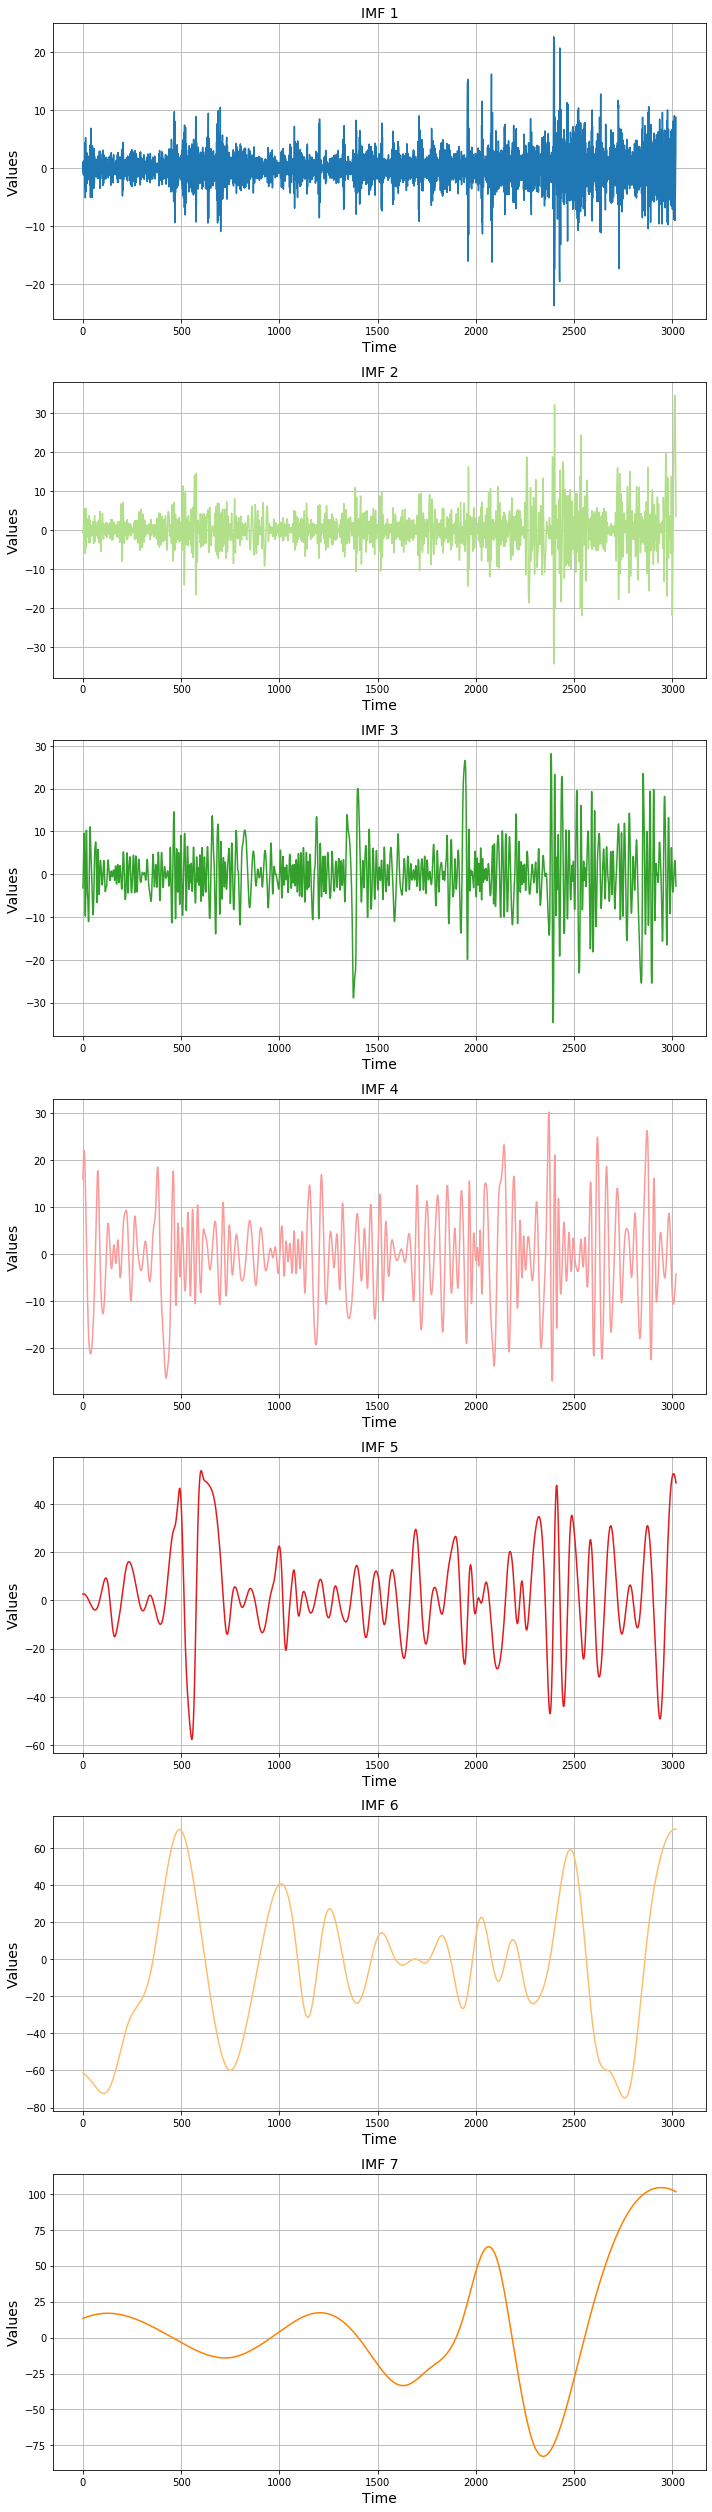

In [26]:
imfs_plot(IMFs)

In [27]:
fourier_IMFs = [np.fft.fft(IMF) for IMF in IMFs]

Applying the Fourier Transform we kinda calculate the tangents and we can see some kinda of deterministic trend.  
After identifying where the trend is strong we can separate the stochatisc part from the deterministic one.

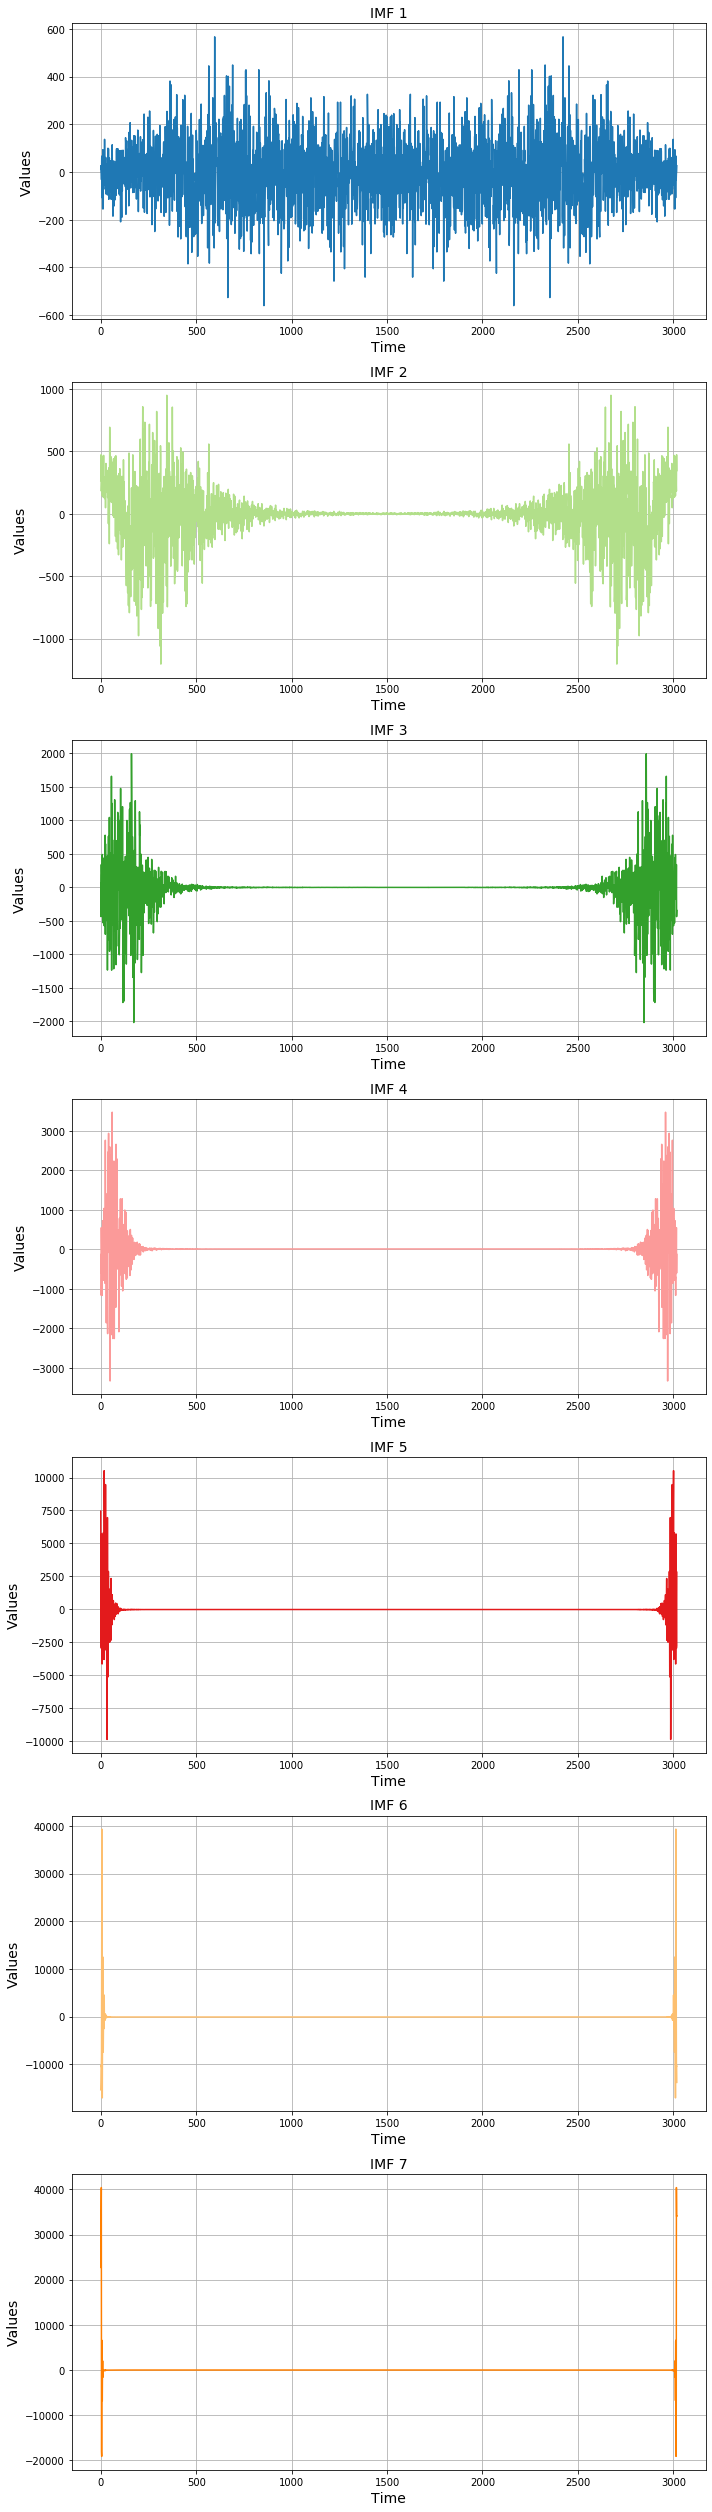

In [28]:
imfs_plot(fourier_IMFs)

Right about the fourth IMF we have some deterministic trend.

In [29]:
stochastic = np.sum(IMFs[:3], axis=0)
deterministic = np.sum(IMFs[3:], axis=0)

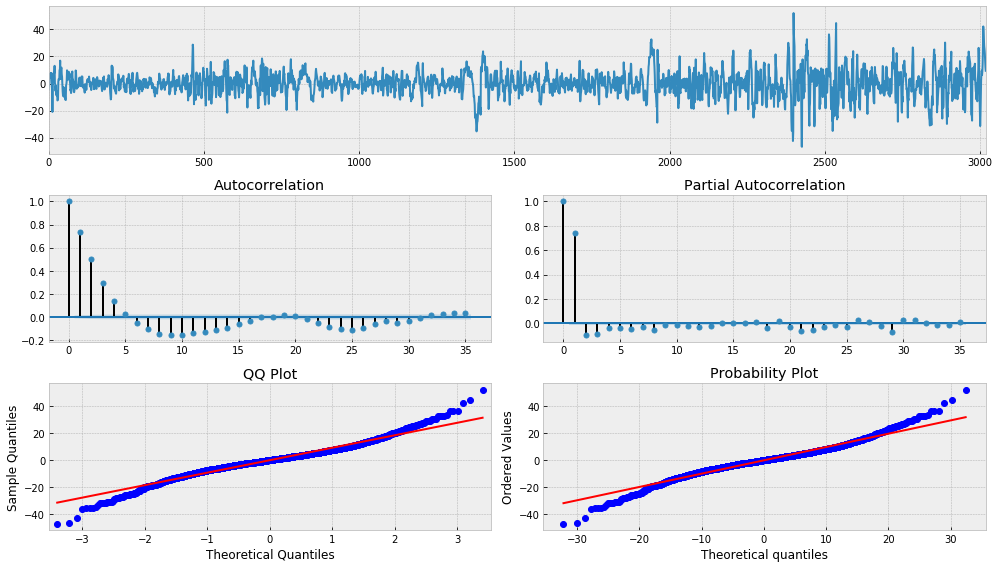

In [30]:
#ts plot for stochastic
tsplot(stochastic)

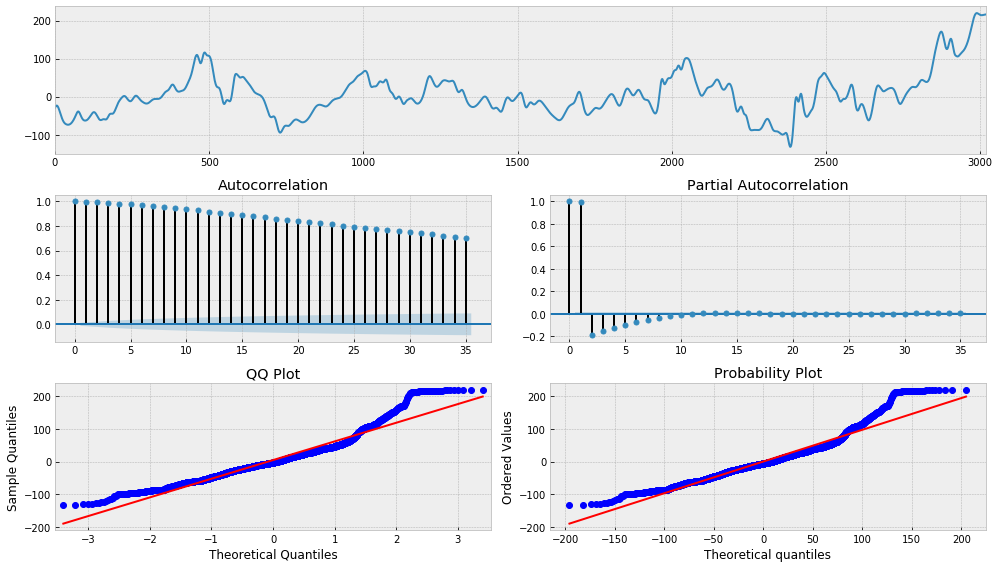

In [31]:
#tsplot deterministic
tsplot(deterministic)